In [197]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier as dtClass
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

df = pd.read_csv('C:\\Users\\gast\\Desktop\\PSn\\lab3\\german_credit_data.csv') 
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,996,40,male,3,own,little,little,3857,30,car
997,997,38,male,2,own,little,NaN,804,12,radio/TV
998,998,23,male,2,free,little,little,1845,45,radio/TV


In [198]:
df.drop(df.columns[0],1,inplace=True)
df

C:\Users\gast\AppData\Local\Temp/ipykernel_13096/3718353601.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns[0],1,inplace=True)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,40,male,3,own,little,little,3857,30,car
997,38,male,2,own,little,NaN,804,12,radio/TV
998,23,male,2,free,little,little,1845,45,radio/TV


In [199]:
df['Purpose'].value_counts().sort_index() 

df['Purpose'] = df['Purpose'].apply(lambda x: 'Other' if (x != 'car' and x!= 'radio/TV') else x)

df['Purpose'].value_counts().sort_index() 


Other       383
car         337
radio/TV    280
Name: Purpose, dtype: int64

In [200]:
dfhead10=df.head(10).copy()
dfhead10

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,Other
3,45,male,2,free,little,little,7882,42,Other
4,53,male,2,free,little,little,4870,24,car
5,35,male,1,free,NaN,NaN,9055,36,Other
6,53,male,2,own,quite rich,NaN,2835,24,Other
7,35,male,3,rent,little,moderate,6948,36,car
8,61,male,1,own,rich,NaN,3059,12,radio/TV
9,28,male,3,own,little,moderate,5234,30,car


In [201]:
#Sugestão: dataDesc={'Age':'Cont', .... }
dataDesc={'Age':'Cont',
        'Sex':'Disc',
        'Job':'Disc',
        'Housing':'Disc',
        'Saving accounts':'Disc',
        'Checking account':'Disc',
        'Credit amount':'Cont',
        'Duration':'Cont'}
dataDesc

{'Age': 'Cont',
 'Sex': 'Disc',
 'Job': 'Disc',
 'Housing': 'Disc',
 'Saving accounts': 'Disc',
 'Checking account': 'Disc',
 'Credit amount': 'Cont',
 'Duration': 'Cont'}

In [202]:
# Handling missing values
for col in dfhead10:
    if dfhead10[col].isnull().values.any():
        if(dataDesc[col]=='Cont'):
            #-----Contínua------- Critério de valor médio              
            dfhead10[col].loc[dfhead10[col].isna()] = dfhead10["Purpose"].apply(lambda x: dfhead10[col].loc[dfhead10['Purpose'] == x].mean() )
             
            
        else:
            #-----Discreta------- Valor marioritário na classe
            dfhead10[col].loc[dfhead10[col].isna()] = dfhead10["Purpose"].apply(lambda x: dfhead10[['Purpose', col]].value_counts()[x].idxmax() )


c:\Users\gast\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [203]:
# Gini impurity function
def gini(listProb):
    return 1 - sum([val**2 for val in listProb])
gini([0.25,0.25,0.25,0.25])

0.75

In [204]:
# Entropy function
def entropia(listProb):
    return -sum([val*np.log2(val) for val in listProb])
entropia([0.25,0.25,0.25,0.25])

2.0

In [205]:
# Function to calculate probability of each class value
def CalcProb(valIn, classe):
    listaProb=[]
    for val in valIn[classe].unique():
        listaProb.append(valIn[classe].value_counts()[val]/len(valIn[classe]))
    return listaProb

In [206]:
def CalcDT(dfIn,vars,classe,ef):
    bestVar = -1
    bestImp = -1
    bestTest = -1
    
    if(ef(CalcProb(dfIn, classe)) == 0): #se impuridade de entrada é 0
        return (['NODE', dfIn[classe].unique()[0]])
    
    for v in vars:        
        vals = sorted(dfIn[v].unique())
        
        if(dataDesc[v]=='Cont'):
            #-----Contínua------- 
            for i in range(1,len(vals)):
                valMed = (vals[i]+vals[i-1])/2
                valLeft = dfIn[dfIn[v]<valMed] 
                valRight = dfIn[dfIn[v]>=valMed]
                
                impLeft = ef(CalcProb(valLeft,classe))
                impRight = ef(CalcProb(valRight,classe))
                
                probLeft= len(valLeft)/len(dfIn)
                probRight= len(valRight)/len(dfIn)                
                impTot = probLeft*impLeft + probRight*impRight            
                
                if(bestImp>impTot or bestImp==-1):
                    bestImp=impTot
                    bestTest = valMed
                    bestVar = v                 
        else:
            #-----Discreta-------
            for i in range(1, len(vals)):
                valLeft = dfIn[dfIn[v]<vals[i]]
                valRight = dfIn[dfIn[v]>=vals[i]]

                impLeft = ef(CalcProb(valLeft,classe))
                impRight = ef(CalcProb(valRight,classe))
                
                probLeft= len(valLeft)/len(dfIn)
                probRight= len(valRight)/len(dfIn)                
                impTot = probLeft*impLeft + probRight*impRight
            
                if(bestImp>impTot or bestImp==-1):
                    bestImp=impTot
                    bestTest = vals[i]
                    bestVar = v 
    
    valLeft = dfIn[dfIn[bestVar]<bestTest]
    valRight = dfIn[dfIn[bestVar]>=bestTest]
        
    return([bestVar, bestTest, CalcDT(valLeft, vars, classe, ef), CalcDT(valRight, vars, classe, ef)])

In [207]:
CalcDT(dfhead10, dfhead10.columns.drop('Purpose'),'Purpose',entropia)

['Age',
 57.0,
 ['Checking account',
  'moderate',
  ['Age',
   51.0,
   ['NODE', 'Other'],
   ['Housing', 'own', ['NODE', 'car'], ['NODE', 'Other']]],
  ['Age', 25.0, ['NODE', 'radio/TV'], ['NODE', 'car']]],
 ['NODE', 'radio/TV']]

In [208]:

discToNumeric={'male':0, 
               'female':1, 
               'own':0, 
               'free':1, 
               'rent':2, 
               'little':0, 
               'quite rich':1, 
               'rich':2, 
               'moderate':1, 
               'radio/TV':0,
               'Other':1, 
               'car':2}

for col in dfhead10: 
        dfhead10[col]=dfhead10[col].apply(lambda x: discToNumeric[x] if x in discToNumeric else x)
dfhead10

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,0,2,0,0,0,1169,6,0
1,22,1,2,0,0,1,5951,48,0
2,49,0,1,0,0,0,2096,12,1
3,45,0,2,1,0,0,7882,42,1
4,53,0,2,1,0,0,4870,24,2
5,35,0,1,1,0,0,9055,36,1
6,53,0,2,0,1,0,2835,24,1
7,35,0,3,2,0,1,6948,36,2
8,61,0,1,0,2,0,3059,12,0
9,28,0,3,0,0,1,5234,30,2


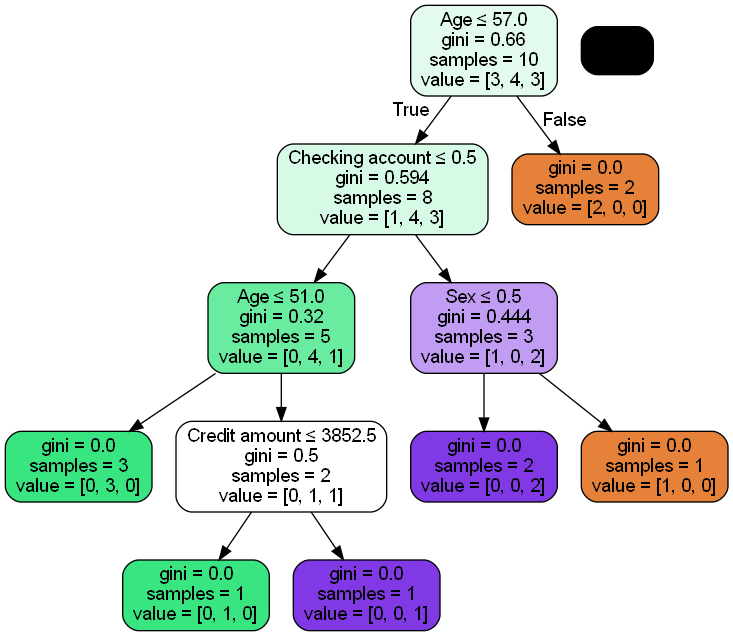

In [209]:
import pydotplus
from sklearn.tree import DecisionTreeClassifier

GCdata = dfhead10ver1.drop('Purpose', axis=1)
GCTarget =  dfhead10ver1['Purpose']

clf = DecisionTreeClassifier(random_state=0)
clf.fit(GCdata, GCTarget) 

import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, 
                feature_names=list(GCdata.columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())